- BERT4Recに変更

In [1]:
import sys

sys.path.append("..")

In [2]:
import random

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import r2_score, roc_auc_score, roc_curve

from src.util import *
from src.model import *

tqdm.pandas()

In [11]:
last_review_date = pd.to_datetime("2015/01/01")
train_split_date = pd.to_datetime("2017/01/01")
test_split_date = pd.to_datetime("2018/01/01")

MASK_TOKEN = "[mask]"
PADDING_TOKEN = "[pad]"

seed = 0
random.seed(seed)
np.random.seed(seed)

In [12]:
class Dataset(torch.utils.data.Dataset):
    """
    self.features = [(user_id, [context_item_id])]
    self.target_items = [[target_item]]
    self.clv = [clv_value]
    """

    def __init__(
        self,
        sequences: dict[int, list[int]],
        train_retention_users: set[int],
        test_retention_users: set[int],
        test_target_items: dict[int, list[int]],
    ):
        """
        Args:
            sequences (dict[int, list[int]]):
                ユーザごとの購買商品系列
                [user_id : user_items]
            clv_dict (dict[int, float]):
                ユーザのCLV
                [user_id : clv_value]
            target_items (dict[int, list[int]]):
                ユーザの将来CV商品
                [user_id : target_items]
        """
        self.user_idx = []
        self.sequences = []
        self.test_target_items = []
        self.train_retention = []
        self.test_retention = []

        for user_idx, sequence in tqdm(sequences.items()):
            self.user_idx.append(user_idx)
            self.sequences.append(sequence)
            self.test_target_items.append(
                test_target_items[user_idx] if user_idx in test_target_items else []
            )
            self.train_retention.append(1 if user_idx in train_retention_users else 0)
            self.test_retention.append(1 if user_idx in test_retention_users else 0)

    def __len__(self) -> int:
        return len(self.user_idx)

    def __getitem__(self, idx: int) -> tuple[int, list[int], list[int], int, int]:
        return (
            self.user_idx[idx],
            self.sequences[idx],
            self.test_target_items[idx],
            self.train_retention[idx],
            self.test_retention[idx],
        )


def create_dataset(
    interaction_df: pd.DataFrame,
    train_split_date: pd.Timestamp | str,
    test_split_date: pd.Timestamp | str,
    item_size: int,
) -> tuple[Dataset, Dataset, np.ndarray, np.ndarray, NegativeSampler]:
    # TODO: refactor
    train_df = (
        interaction_df[interaction_df.timestamp < test_split_date]
        .sort_values("timestamp")
        .reset_index(drop=True)
    )
    test_df = (
        interaction_df[interaction_df.timestamp >= test_split_date]
        .sort_values("timestamp")
        .reset_index(drop=True)
    )
    retention_feature_df = (
        interaction_df[interaction_df.timestamp < train_split_date]
        .sort_values("timestamp")
        .reset_index(drop=True)
    )
    retention_target_df = (
        interaction_df[
            (interaction_df.timestamp >= train_split_date)
            & (interaction_df.timestamp < test_split_date)
        ]
        .sort_values("timestamp")
        .reset_index(drop=True)
    )

    train_sequences = train_df.groupby("user_id").item_id.agg(list).to_dict()
    train_user_feature_table = create_user_features(
        feature_df=retention_feature_df, split_date=train_split_date
    ).values.astype(np.float32)
    test_user_feature_table = create_user_features(
        feature_df=train_df.reset_index(drop=True),
        split_date=test_split_date,
    ).values.astype(np.float32)

    train_retention_users = set(retention_target_df.user_id.values)
    test_retention_users = set(test_df.user_id.values)
    test_target_items = test_df.groupby("user_id").item_id.agg(list).to_dict()

    dataset = Dataset(
        sequences=train_sequences,
        train_retention_users=train_retention_users,
        test_retention_users=test_retention_users,
        test_target_items=test_target_items,
    )

    negative_sampler = NegativeSampler(sequences=train_sequences, item_size=item_size)

    return (
        dataset,
        train_user_feature_table,
        test_user_feature_table,
        negative_sampler,
    )


def create_random_mask(shape: torch.Size | tuple, rho: float = 0.2) -> np.array:
    return np.random.random(shape) < rho

In [13]:
interaction_df, user_le, item_le = load_interaction_df(
    last_review_date=last_review_date,
    train_split_date=train_split_date,
    padding_token=PADDING_TOKEN,
    mask_token=MASK_TOKEN,
)
items = item_le.transform(item_le.classes_)
mask_idx, padding_idx = item_le.transform([MASK_TOKEN, PADDING_TOKEN])

(
    dataset,
    train_user_feature_table,
    test_user_feature_table,
    negative_sampler,
) = create_dataset(
    interaction_df=interaction_df,
    train_split_date=train_split_date,
    test_split_date=test_split_date,
    item_size=len(item_le.classes_)
)

100%|██████████| 25093/25093 [00:00<00:00, 2912624.06it/s]


In [127]:
class Model4(torch.nn.Module):
    def __init__(
        self,
        item_size: int,
        user_feature_dim: int,
        num_layers: int = 4,
        d_model: int = 64,
        dim_feedforward: int = 128,
        nhead: int = 4,
    ) -> None:
        super().__init__()
        self.user_embedding = torch.nn.Linear(user_feature_dim, d_model)
        self.item_embedding = torch.nn.Embedding(item_size, d_model)

        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.transformer_layer = torch.nn.TransformerEncoder(
            encoder_layer=torch.nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                batch_first=True,
            ),
            num_layers=num_layers,
            # mask_check=False,
        )
        self.clv_layer = TwoFeedForwardLayer(d_model, d_model // 2, 1)
        self.target_layer = TwoFeedForwardLayer(d_model, d_model * 2, d_model)

    def forward(
        self,
        user_features: torch.Tensor,
        item_indices: torch.Tensor,
        target_indices: torch.Tensor,
        padding_mask: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        e_u = self.user_embedding.forward(user_features)
        e_v = self.item_embedding.forward(item_indices)
        e_v = self.positional_encoding.forward(e_v)
        H = torch.cat((e_u.unsqueeze(1), e_v), dim=1)
        H = self.transformer_layer.forward(H, src_key_padding_mask=padding_mask)

        y_clv = torch.sigmoid(self.clv_layer.forward(H[:, 0]))
        H_v = self.target_layer.forward(H[:, 1:])

        e_target = self.item_embedding.forward(target_indices)
        v_target = torch.matmul(H_v.unsqueeze(-2), e_target.mT)
        y_target = torch.sigmoid(v_target)

        return y_clv.squeeze(), y_target.squeeze()

In [135]:
def run_one_epoch(
    model: Model4,
    dataloader: torch.utils.data.DataLoader,
    user_feature_table: np.ndarray,
    negative_sampler: NegativeSampler,
    optimizer: torch.optim.Optimizer,
    args: Args,
    is_eval: bool = False,
) -> dict:
    result: dict[str, dict] = {
        "target": {"loss": 0.0, "y_pred": [], "y_true": []},
        "clv": {"loss": 0.0, "y_pred": [], "y_true": []},
    }

    if is_eval:
        model.eval()
    else:
        model.train()

    for batch in tqdm(dataloader):
        user_ids = []
        item_indices = []
        target_indices = []
        target_labels = []
        retention_labels = []
        last_prediction_mask = []

        for user_id, user_context_items, _, train_retention, _ in batch:
            s = random.randrange(0, len(user_context_items))
            context_items = user_context_items[s : s + args.context_item_size]
            last_prediction_mask.append([False] * args.context_item_size)
            last_prediction_mask[-1][len(context_items) - 1] = True
            context_items.extend(
                [padding_idx] * (args.context_item_size - len(context_items))
            )

            user_ids.append(user_id)
            item_indices.append(context_items)
            retention_labels.append(train_retention)
            target = negative_sampler.sample(
                shape=(args.context_item_size, 1 + args.negative_sample_size)
            )
            target[:, 0] = context_items
            target_indices.append(target.tolist())
            target_labels.append(
                [
                    [1] + [0] * args.negative_sample_size
                    for _ in range(args.context_item_size)
                ]
            )

        user_features = torch.FloatTensor(user_feature_table[user_ids]).to(args.device)
        item_indices = torch.LongTensor(item_indices).to(args.device)
        # torch.save(item_indices, "item_indices0.pt")

        if random.random() < 1.:
            mask = torch.BoolTensor(
                create_random_mask(shape=item_indices.shape, rho=0.2).tolist()
            ).to(args.device)
        else:
            mask = torch.BoolTensor(last_prediction_mask).to(args.device)
        mask = mask & (item_indices != padding_idx)
        item_indices[mask] = mask_idx

        src_key_padding_mask = torch.cat(
            [
                torch.BoolTensor([False for _ in range(item_indices.shape[0])])
                .unsqueeze(1)
                .to(args.device),
                item_indices == padding_idx,
            ],
            dim=1,
        ).transpose(0, 1)
        target_indices = torch.LongTensor(target_indices).to(args.device)
        target_labels = torch.FloatTensor(target_labels).to(args.device)
        retention_labels = torch.FloatTensor(retention_labels).to(args.device).flatten()

        y_clv, y_target = model.forward(
            user_features, item_indices, target_indices, src_key_padding_mask
        )
        # print(item_indices.shape, y_target.shape, target_labels.shape)
        y_clv = y_clv.flatten()
        y_target = y_target[mask].flatten()
        target_labels = target_labels[mask].flatten()
        # print(item_indices.shape, y_target.shape, target_labels.shape)
        # torch.save(mask, "mask.pt")
        # torch.save(target_labels, "target_labels.pt")
        # torch.save(item_indices, "item_indices.pt")
        # torch.save(target_indices, "target_indices.pt")
        # torch.save(y_target, "y_target.pt")
        # torch.save(src_key_padding_mask, "src_key_padding_mask.pt")

        target_loss = torch.nn.functional.binary_cross_entropy(y_target, target_labels)
        clv_loss = torch.nn.functional.binary_cross_entropy(y_clv, retention_labels)

        loss = target_loss * args.alpha + clv_loss * (1 - args.alpha)

        if not is_eval:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        result["target"]["loss"] += target_loss.item()
        result["target"]["y_pred"].extend(y_target.tolist())
        result["target"]["y_true"].extend(target_labels.tolist())
        result["clv"]["loss"] += clv_loss.item()
        result["clv"]["y_pred"].extend(y_clv.tolist())
        result["clv"]["y_true"].extend(retention_labels.tolist())

    for term_name in result.keys():
        result[term_name]["loss"] /= len(dataloader)

    return result


def train(
    model: Model4,
    dataset: Dataset,
    train_user_feature_table: np.ndarray,
    test_user_feature_table: np.ndarray,
    negative_sampler: NegativeSampler,
    args: Args,
) -> tuple[list[dict], list[dict]]:
    train_dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=args.batch_size,
        shuffle=True,
        collate_fn=lambda x: x,  # 各データは形式が異なるため、バッチ化せずにそのまま返す
    )
    test_dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda x: x,  # 各データは形式が異なるため、バッチ化せずにそのまま返す
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    train_results = []
    test_results = []

    for epoch in range(args.epochs):
        print(f"[epoch: {epoch + 1}/{args.epochs}]")
        train_result = run_one_epoch(
            model=model,
            dataloader=train_dataloader,
            user_feature_table=train_user_feature_table,
            negative_sampler=negative_sampler,
            optimizer=optimizer,
            args=args,
        )
        print(
            f"[train][loss] target_loss: {train_result['target']['loss']:.6f}, clv_loss: {train_result['clv']['loss']:.6f}"
        )
        print(roc_auc_score(
            train_result["target"]["y_true"], train_result["target"]["y_pred"]
        ))
        train_results.append(train_result)

        test_result = run_one_epoch(
            model=model,
            dataloader=test_dataloader,
            user_feature_table=test_user_feature_table,
            negative_sampler=negative_sampler,
            optimizer=optimizer,
            args=args,
            is_eval=True,
        )
        print(
            f"[test][loss] target_loss: {test_result['target']['loss']:.6f}, clv_loss: {test_result['clv']['loss']:.6f}"
        )
        test_results.append(test_result)

        torch.save(model, args.model_path)
        print(f"saved model to: {args.model_path}")

    return train_results, test_results

In [136]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

target_loss_weight = 1
clv_loss_weight = 0
alpha = target_loss_weight / (target_loss_weight + clv_loss_weight)

args = Args(
    d_model=32,
    dim_feedforward=64,
    batch_size=64,
    nhead=4,
    num_layers=4,
    epochs=5,
    lr=1e-3,
    sample_size=5,
    negative_sample_size=100,
    alpha=alpha,
    context_item_size=50,
    device=device,
    model_path="model4_6.model",
)

try:
    model = torch.load(args.model_path)
    print(f"loaded model from: {args.model_path}")
except FileNotFoundError:
    model = Model4(
        item_size=len(items),
        user_feature_dim=train_user_feature_table.shape[1],
        d_model=args.d_model,
        dim_feedforward=args.dim_feedforward,
        nhead=args.nhead,
        num_layers=args.num_layers,
    )
model.to(args.device)
model.train()

print(f"args: {args}")
train_results, test_results = train(
    model=model,
    dataset=dataset,
    train_user_feature_table=train_user_feature_table,
    test_user_feature_table=test_user_feature_table,
    negative_sampler=negative_sampler,
    args=args,
)

args: Args(d_model=32, dim_feedforward=64, batch_size=64, nhead=4, num_layers=4, epochs=5, lr=0.001, sample_size=5, negative_sample_size=100, alpha=1.0, context_item_size=50, device='mps', model_path='model4_6.model')
[epoch: 1/5]


  0%|          | 0/393 [00:00<?, ?it/s]


AssertionError: expecting key_padding_mask shape of (64, 51), but got torch.Size([51, 64])

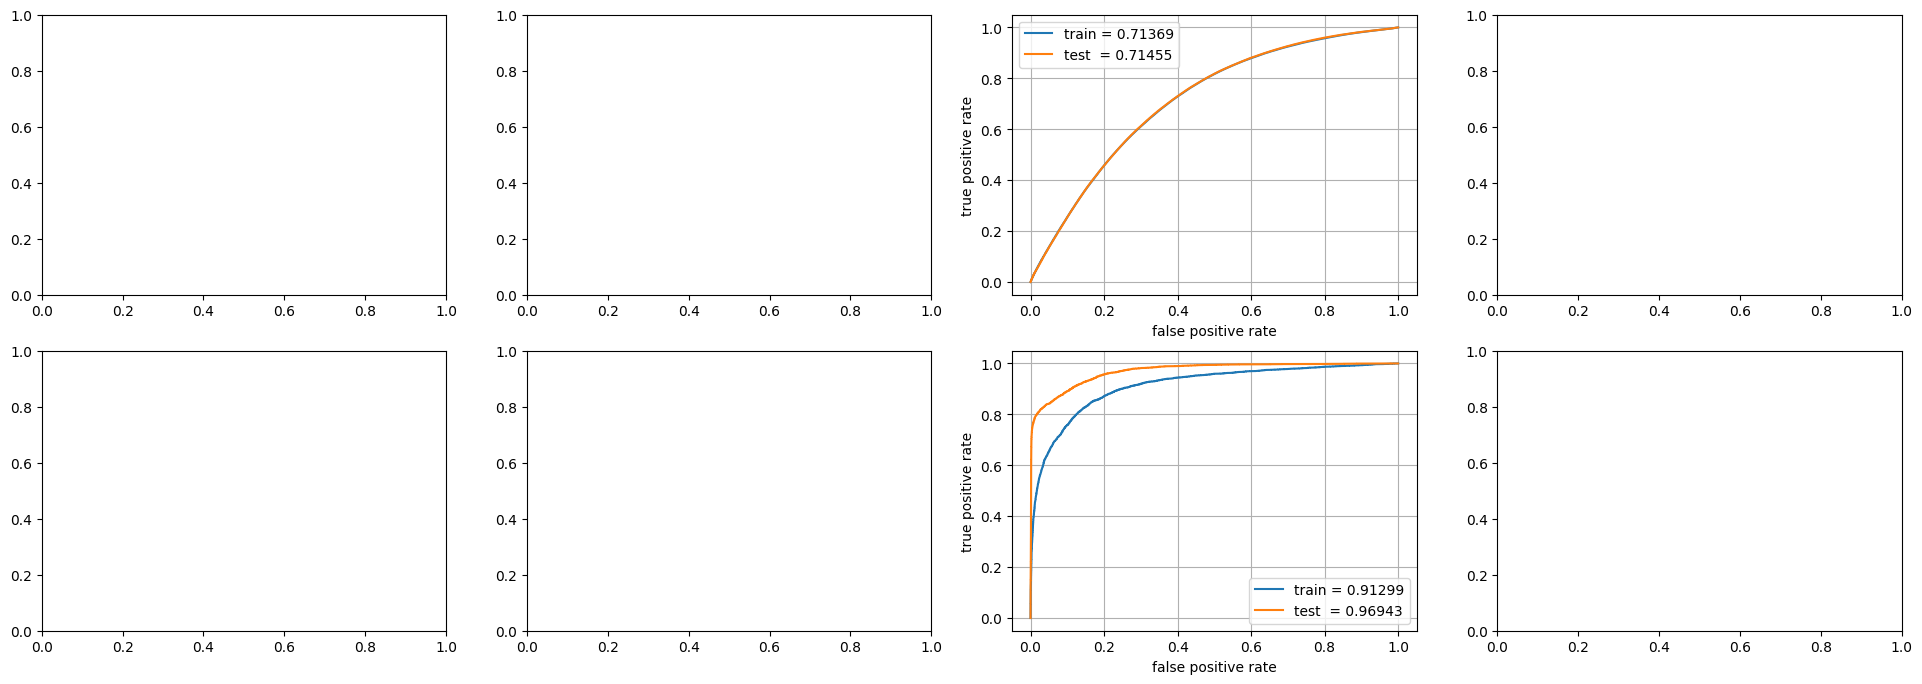

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 8))
loss_names = ["target", "clv"]

for i, loss_name in enumerate(loss_names):
    plot_loss(train_results, test_results, loss_name, axes[i, 0])
    plot_r2_score(train_results, test_results, loss_name, axes[i, 1])
    plot_roc_auc(train_results[-1], test_results[-1], loss_name, axes[i, 2])
    plot_auc(train_results, test_results, loss_name, axes[i, 3])

plt.show()

In [ ]:
# for user_id, user_context_items, test_target_items, clv in tqdm(dataset):
#     if len(test_target_items) == 0:
#         continue
#     user_ids = []
#     item_indices = []
#     for _ in range(2):
#         context_item_indices = []
#         for _ in range(args.context_item_size):
#             context_item_indices.append(random.randrange(len(user_context_items)))
#         context_item_indices.sort()
#         context_items = [user_context_items[i] for i in context_item_indices]

#         user_ids.append(user_id)
#         item_indices.append(context_items)

#     user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
#     item_indices = torch.LongTensor(item_indices).to(args.device)
#     target_indices = torch.LongTensor(items).to(args.device)

#     with torch.no_grad():
#         e_u = model.user_embedding.forward(user_features)
#         e_v = model.item_embedding.forward(item_indices)
#         e_v = model.positional_encoding.forward(e_v)
#         H = torch.cat((e_u.unsqueeze(1), e_v), dim=1)
#         H = model.transformer_layer.forward(H)

#         y_clv = torch.sigmoid(model.clv_layer.forward(H[:, 0]))
#         H_v = model.target_layer.forward(H[:, -1])

#         e_target = model.item_embedding.forward(target_indices)
#         v_target = torch.matmul(H_v.unsqueeze(1), e_target.mT)
#         y_target = torch.sigmoid(v_target)
#         # print(H.shape, H)
#         x = H[:, -1]
#         # print("1:", x)
#         x = model.target_layer.fc1.forward(x)
#         # print("2:", x)
#         x = torch.nn.functional.leaky_relu(x)
#         # print("3:", x)
#         x = model.target_layer.fc2.forward(x)
#         # print("4:", x)
#         # print("b:", model.target_layer.fc2.bias)
#         # print(H_v)
#         # print(e_target)
#         # print(v_target)
#         print(y_target[0][0][:7])

In [ ]:
model.eval()

before_rerank_size = 50
filter_sample_size = 10
rerank_sample_size = 10
top_k = 10

total_count = 0
before_hit_count = 0
after_hit_count = 0

recommendations = {}

for user_id, user_context_items, test_target_items, _, test_retention in tqdm(dataset):
    if len(test_target_items) == 0:
        continue
    total_count += 1

    recommendations[user_id] = {}

    user_ids = []
    item_indices = []

    context_items = user_context_items[-args.context_item_size :]
    prediction_mask = [False] * (args.context_item_size + 1)
    prediction_mask[len(context_items)] = True
    context_items.extend(
        [padding_idx] * (args.context_item_size + 1 - len(context_items))
    )
    user_ids.append(user_id)
    item_indices.append(context_items)

    user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
    item_indices = torch.LongTensor(item_indices).to(args.device)
    target_indices = torch.LongTensor(items).to(args.device)

    mask = torch.BoolTensor(prediction_mask).to(args.device)
    mask = (mask & (item_indices != padding_idx)).nonzero()
    item_indices[mask] = mask_idx

    # print(torch.BoolTensor([True for _ in range(item_indices.shape[0])]).unsqueeze(1).to(args.device).shape)
    # print((item_indices == PADDING_IDX).shape)
    src_key_padding_mask = torch.cat(
        [
            torch.BoolTensor([True for _ in range(item_indices.shape[0])])
            .unsqueeze(1)
            .to(args.device),
            item_indices == padding_idx,
        ],
        dim=1,
    )

    with torch.no_grad():
        _, y_target = model.forward(
            user_features,
            item_indices,
            target_indices=target_indices,
            padding_mask=src_key_padding_mask,
        )

    b = y_target.mean(dim=0).cpu().detach().numpy()

    before_rerank_rec = items[np.argsort(b)][::-1][
        :before_rerank_size
    ]  # 降順でソートし、上位`before_rerank_size`件を取得する

    hit = len(set(before_rerank_rec[:top_k]) & set(test_target_items))
    # print("before rerank:", hit, "/", len(target_items))
    if hit > 0:
        before_hit_count += 1

    # clv_mean = []
    # user_ids = []
    # item_indices = []
    # for target_item in before_rerank_rec:
    #     for _ in range(rerank_sample_size):
    #         context_item_indices = []
    #         for _ in range(args.context_item_size):
    #             context_item_indices.append(random.randrange(len(user_context_items)))
    #         context_item_indices.sort()
    #         context_items = [user_context_items[i] for i in context_item_indices]

    #         v = list(context_items)
    #         v.append(target_item)
    #         user_ids.append(user_id)
    #         item_indices.append(v)

    # user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
    # item_indices = torch.LongTensor(item_indices).to(args.device)
    # target_indices = torch.LongTensor([0]).to(args.device)  # CLVのみを計算するので、ダミーを入れておく

    # with torch.no_grad():
    #     y_clv, _ = model.forward(user_features, item_indices, target_indices)

    # y_clv = y_clv.cpu().detach().numpy()
    # clv_mean = np.add.reduceat(y_clv, np.arange(0, y_clv.shape[0], rerank_sample_size))

    # after_rerank_rec = before_rerank_rec[np.argsort(clv_mean)][::-1]

    # hit = len(set(after_rerank_rec[:top_k]) & set(test_target_items))

    # # print("after rerank:", hit, "/", len(target_items))
    # if hit > 0:
    #     after_hit_count += 1

    recommendations[user_id]["target_items"] = item_le.inverse_transform(
        test_target_items
    ).tolist()
    recommendations[user_id]["before_rerank_rec"] = item_le.inverse_transform(
        before_rerank_rec
    ).tolist()
    # recommendations[user_id]["before_rerank_rec_value"] = b[before_rerank_rec].tolist()
    # recommendations[user_id]["after_rerank_rec"] = item_le.inverse_transform(
    #     after_rerank_rec
    # ).tolist()
    # recommendations[user_id]["after_rerank_rec_value"] = b[after_rerank_rec].tolist()


print(f"before hit-ratio:  {before_hit_count / total_count:.5f}")
print(f"after hit-ratio:   {after_hit_count / total_count:.5f}")

100%|██████████| 25093/25093 [01:18<00:00, 319.34it/s]

before hit-ratio:  0.00169
after hit-ratio:   0.00000


In [ ]:
rec_df = pd.DataFrame.from_dict(recommendations, orient="index")
rec_df.index = rec_df.index.rename("user_id")
rec_df.to_csv("../out/rec14.csv")

In [ ]:
print(sorted(rec_df.before_rerank_rec_value.iloc[0], reverse=True))
print(sorted(rec_df.before_rerank_rec_value.iloc[1], reverse=True))

[0.9956567883491516, 0.9806453585624695, 0.9795746803283691, 0.9762765765190125, 0.9682609438896179, 0.9668537378311157, 0.9644695520401001, 0.9592563509941101, 0.947653591632843, 0.9445328116416931, 0.9441224932670593, 0.9412515759468079, 0.9402101635932922, 0.9396970868110657, 0.9376716613769531, 0.9368287920951843, 0.9346016049385071, 0.9345181584358215, 0.9328727126121521, 0.932559609413147, 0.9323291778564453, 0.9306287169456482, 0.9295879602432251, 0.9200443625450134, 0.918958842754364, 0.9178261160850525, 0.9177438020706177, 0.9172148108482361, 0.9159069061279297, 0.91292804479599, 0.9122264981269836, 0.9116663932800293, 0.9110004305839539, 0.9108490347862244, 0.9107282757759094, 0.9104852676391602, 0.910403847694397, 0.9096506237983704, 0.9095926284790039, 0.9057933688163757, 0.9057783484458923, 0.9049334526062012, 0.9031335711479187, 0.9019554257392883, 0.9018646478652954, 0.9002979397773743, 0.8993213772773743, 0.8984493613243103, 0.8984178900718689, 0.8979911804199219]
[0.99